In [1]:
import sys
import os

path2add = os.path.normpath(os.path.abspath('..'))
if path2add not in sys.path: sys.path.append(path2add)

import torch
from torch_geometric.data import Data
from dataloader import GraphDataset, GraphTextDataset, TextDataset, GraphTextInMDataset, AllGraphDataset, AugmentGraphDataset
import networkx as nx

from transformers import AutoTokenizer

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
model_names = ["allenai/scibert_scivocab_uncased", "nlpie/distil-biobert"]

In [20]:
tokenizer_scibert = AutoTokenizer.from_pretrained(model_names[0])
tokenizer_biobert = AutoTokenizer.from_pretrained(model_names[1])

In [84]:
# descriptions = pd.read_csv("../data/text.csv")
descriptions = pd.read_csv("../data/train.tsv", sep="\t")
# Add colmun names
descriptions.columns = ["id", "text"]
descriptions

,id,text
0,46931111,2-acetamido-2-deoxy-3-O-(4-deoxy-alpha-L-threo...
1,743,"Glutaric acid is an alpha,omega-dicarboxylic a..."
2,6151363,All-trans-4-oxoretinal is a retinoid that is a...
3,7344,Ethyl 2-hydroxypropanoate is the ethyl ester o...
4,170780,Alstonine(1+) is an organic cation resulting f...
...,...,...
26402,3014955,3-chlorobenzoate is a chlorobenzoate that is t...
26403,10315720,NK372135B is a dinitrile that is butanedinitri...
26404,52921823,"(14Z,17Z,20Z,23Z,26Z)-dotriacontapentaenoic ac..."
26405,53355130,7-epi-zeaenol is a macrolide that is a C-7 epi...


In [85]:
# Tokenize the text
descriptions["tokenized_text_scibert"] = descriptions["text"].apply(lambda x: tokenizer_scibert.encode(x, add_special_tokens=True, truncation=False, max_length=2048))
descriptions["tokenized_text_biobert"] = descriptions["text"].apply(lambda x: tokenizer_biobert.encode(x, add_special_tokens=True, truncation=False, max_length=2048))

In [86]:
# Plot histogram of tokenized text lengths
descriptions["tokenized_length_scibert"] = descriptions["tokenized_text_scibert"].apply(lambda x: len(x))
descriptions["tokenized_length_biobert"] = descriptions["tokenized_text_biobert"].apply(lambda x: len(x))

In [87]:
import seaborn as sns

759
899


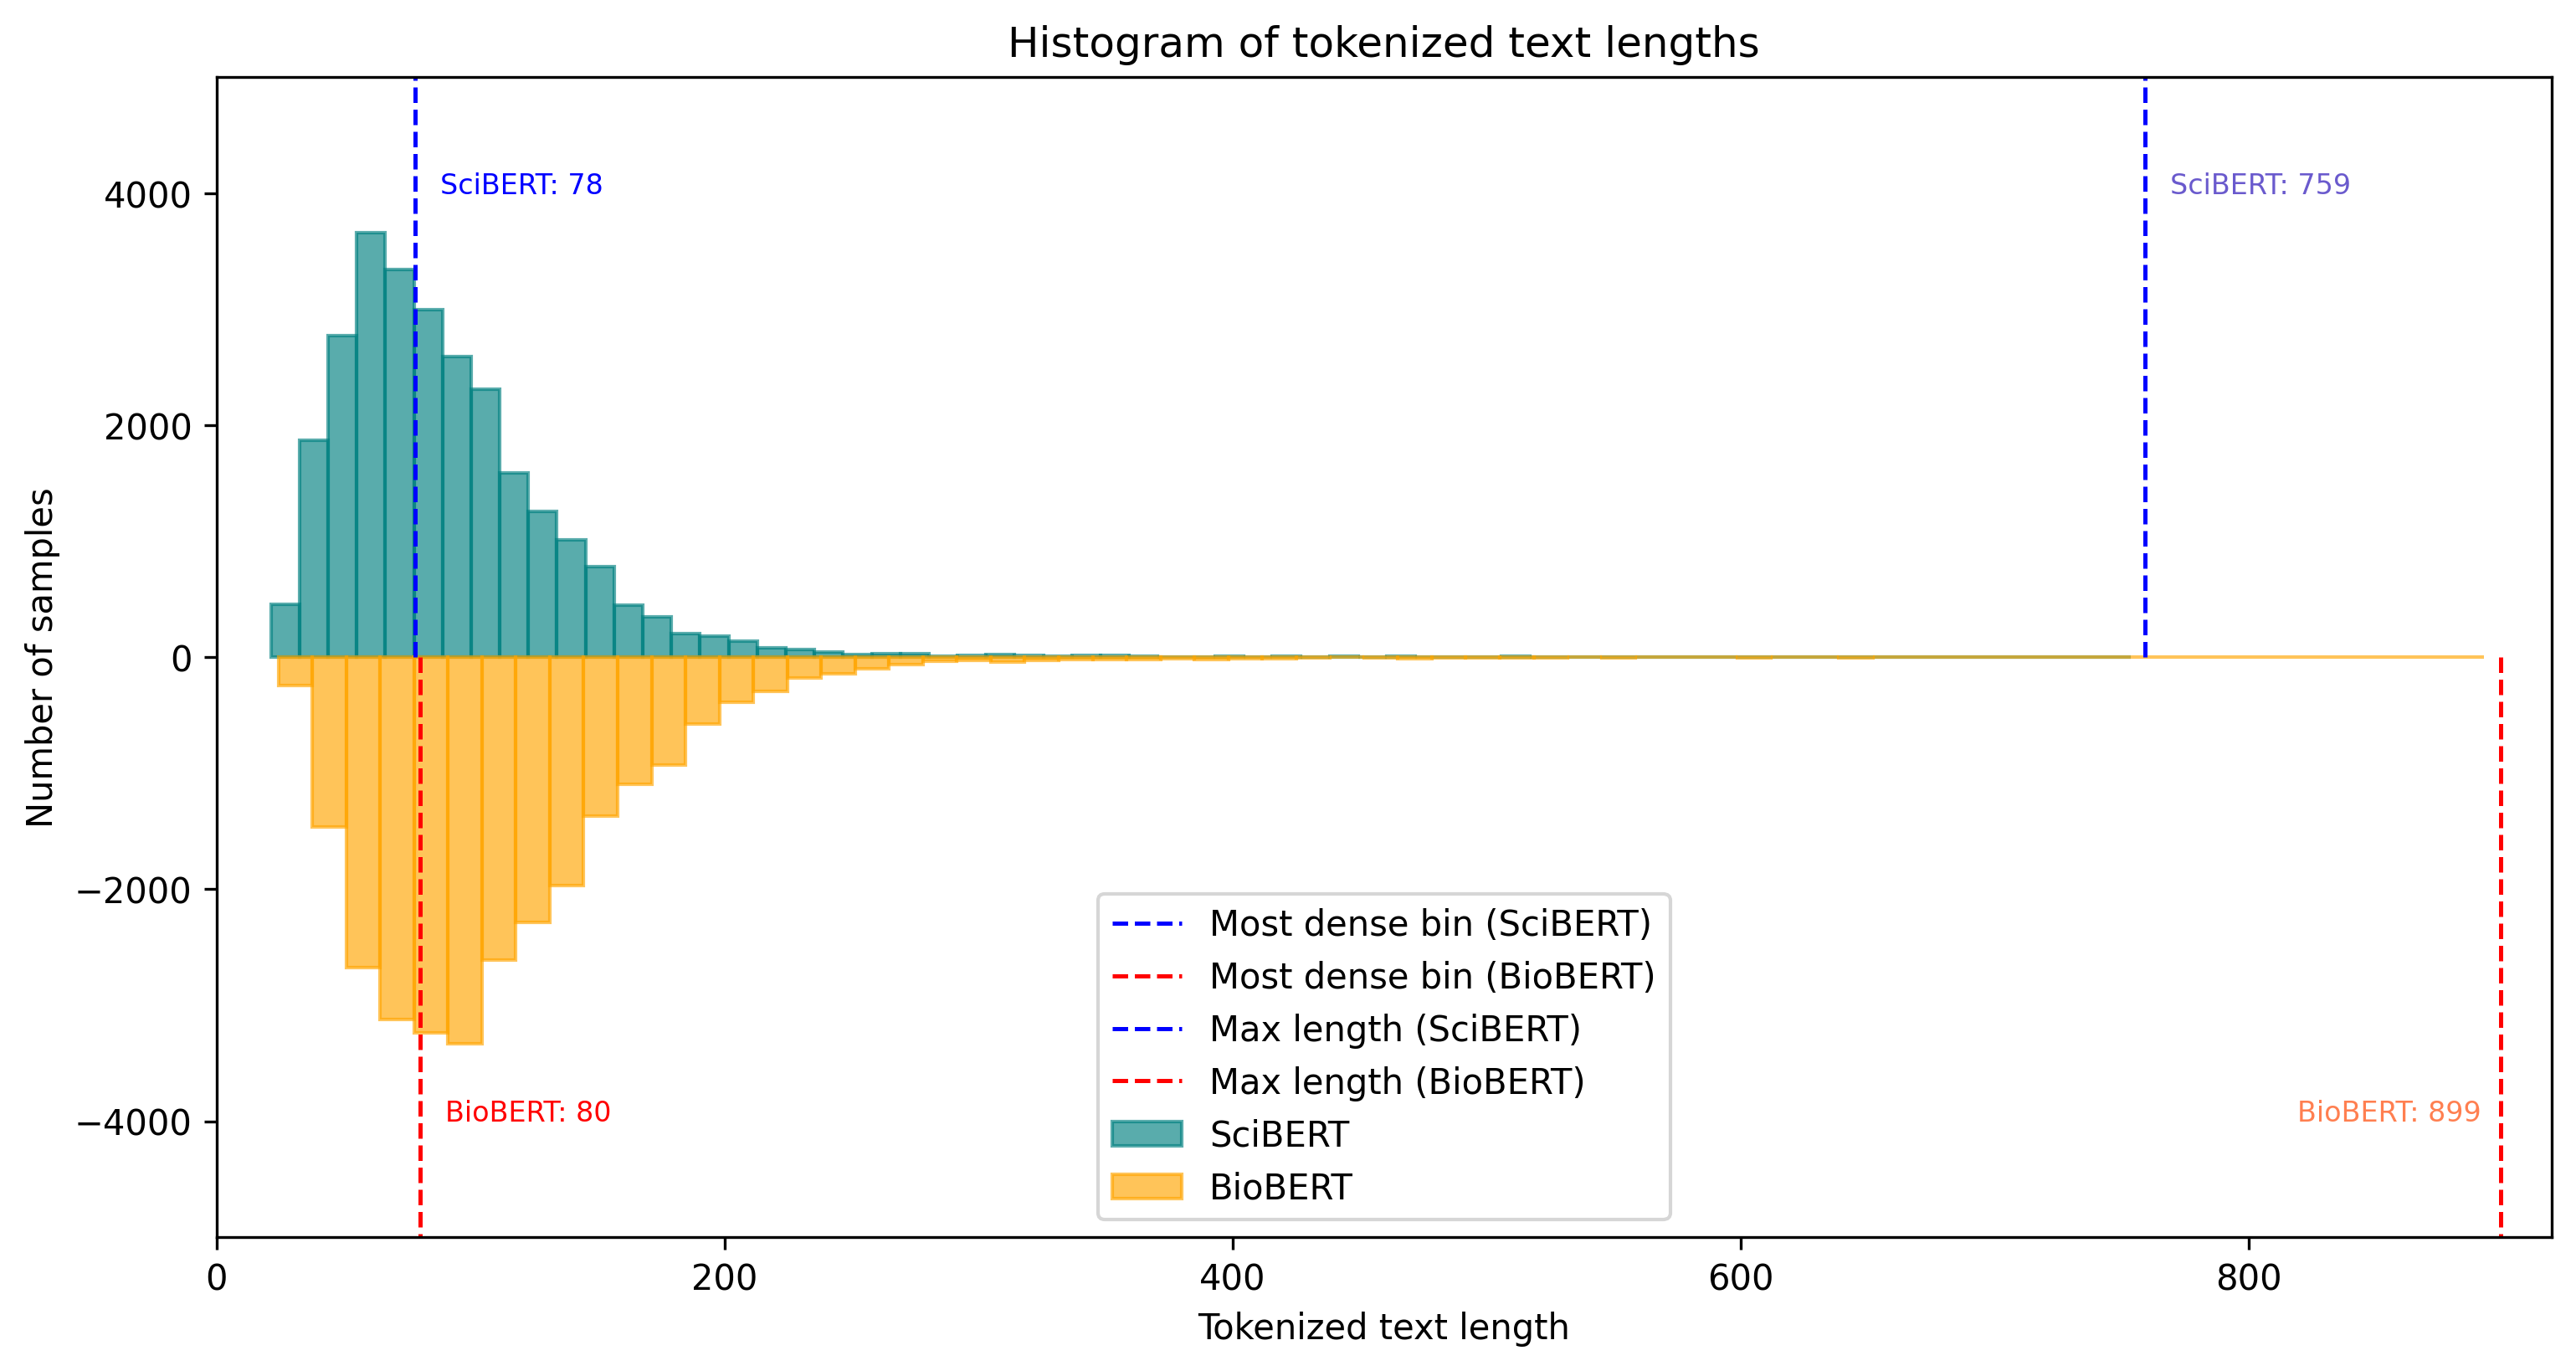

In [97]:
plt.figure(figsize=(12, 6), dpi=300)

heights, bins = np.histogram(descriptions["tokenized_length_scibert"], bins=65, density=False)
bin_width = np.diff(bins)[0]
plt.bar(bins[:-1], heights, width=bin_width, edgecolor='teal', color='teal', label="SciBERT", alpha=0.65)

heights, bins = np.histogram(descriptions["tokenized_length_biobert"], bins=65, density=False)
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos = bins[:-1]
plt.bar(bin_pos, heights, width=bin_width, edgecolor='orange', color='orange', label="BioBERT", alpha=0.65)
print(max(descriptions["tokenized_length_scibert"]))
print(max(descriptions["tokenized_length_biobert"]))

# Add vertical line for bin with most density
max_density_scibert = descriptions["tokenized_length_scibert"].value_counts().idxmax()
max_density_biobert = descriptions["tokenized_length_biobert"].value_counts().idxmax()

# Plot the line from 0 to 4000
plt.plot([max_density_scibert, max_density_scibert], [0, 6000], color='blue', linestyle='--', linewidth=1.2, label="Most dense bin (SciBERT)")
plt.plot([max_density_biobert, max_density_biobert], [0, -6000], color='red', linestyle='--', linewidth=1.2, label="Most dense bin (BioBERT)")

plt.text(max_density_scibert + 10, 4000, f"SciBERT: {max_density_scibert}", color='blue', fontsize=8)
plt.text(max_density_biobert + 10, -4000, f"BioBERT: {max_density_biobert}", color='red', fontsize=8)

max_length_scibert = max(descriptions["tokenized_length_scibert"])
max_length_biobert = max(descriptions["tokenized_length_biobert"])

plt.plot([max_length_scibert, max_length_scibert], [0, 6000], color='blue', linestyle='--', linewidth=1.2, label="Max length (SciBERT)")
plt.plot([max_length_biobert, max_length_biobert], [0, -6000], color='red', linestyle='--', linewidth=1.2, label="Max length (BioBERT)")

plt.text(max_length_scibert + 10, 4000, f"SciBERT: {max_length_scibert}", color='slateblue', fontsize=8)
plt.text(max_length_biobert - 80, -4000, f"BioBERT: {max_length_biobert}", color='coral', fontsize=8)

plt.xlabel("Tokenized text length")
plt.ylabel("Number of samples")
plt.title("Histogram of tokenized text lengths")


plt.xlim(0, max(max_length_scibert, max_length_biobert)+20)
plt.ylim(-5000, 5000)
plt.legend()
plt.savefig("tokenized_text_length.png", dpi=300, transparent=True)

In [89]:
# Get the number of sample with length scibert > 256
print("SciBERT")
print(f"Number of samples with length > 256: {len(descriptions[descriptions['tokenized_length_scibert'] > 256])}")
print(f"Number of samples with length > 512: {len(descriptions[descriptions['tokenized_length_scibert'] > 512])}")

print("BioBERT")
print(f"Number of samples with length > 256: {len(descriptions[descriptions['tokenized_length_biobert'] > 256])}")
print(f"Number of samples with length > 512: {len(descriptions[descriptions['tokenized_length_biobert'] > 512])}")

SciBERT
Number of samples with length > 256: 253
Number of samples with length > 512: 20
BioBERT
Number of samples with length > 256: 504
Number of samples with length > 512: 34


In [69]:
# Read text test_test.txt into dataframe
test_descriptions = pd.read_csv("../data/test_text.txt", sep="\t", header=None)
test_descriptions.columns = ["text"]
test_descriptions

,text
0,Xanthurenate is a quinolinemonocarboxylate tha...
1,"4,4-dimethylcholest-8(14)-en-3beta-ol is a 3be..."
2,Glas#24 is an ascarosyloxycarboxylic acid beta...
3,5'-(N(6)-L-lysine)-L-tyrosylquinone is an L-ly...
4,Diphenyl ether is an aromatic ether in which t...
...,...
3296,"(18S)-resolvin E1 is a resolvin that is (6Z,8E..."
3297,(4-hydroxyphenyl)acetaldehyde is an alpha-CH2-...
3298,Acephate is a phosphoramide that is methamidop...
3299,L-tryptophanamide(1+) is the conjugate acid of...


In [70]:
# Tokenize the text
test_descriptions["tokenized_text_scibert"] = test_descriptions["text"].apply(lambda x: tokenizer_scibert.encode(x, add_special_tokens=True, truncation=False, max_length=2048))
test_descriptions["tokenized_text_biobert"] = test_descriptions["text"].apply(lambda x: tokenizer_biobert.encode(x, add_special_tokens=True, truncation=False, max_length=2048))

In [71]:
# Plot histogram of tokenized text lengths
test_descriptions["tokenized_length_scibert"] = test_descriptions["tokenized_text_scibert"].apply(lambda x: len(x))
test_descriptions["tokenized_length_biobert"] = test_descriptions["tokenized_text_biobert"].apply(lambda x: len(x))

In [72]:
# Get the number of sample with length scibert > 256
print("SciBERT")
print(f"Number of samples with length > 256: {len(test_descriptions[test_descriptions['tokenized_length_scibert'] > 256])}")
print(f"Number of samples with length > 512: {len(test_descriptions[test_descriptions['tokenized_length_scibert'] > 512])}")

print("BioBERT")
print(f"Number of samples with length > 256: {len(test_descriptions[test_descriptions['tokenized_length_biobert'] > 256])}")
print(f"Number of samples with length > 512: {len(test_descriptions[test_descriptions['tokenized_length_biobert'] > 512])}")

SciBERT
Number of samples with length > 256: 37
Number of samples with length > 512: 3
BioBERT
Number of samples with length > 256: 62
Number of samples with length > 512: 5


612
717


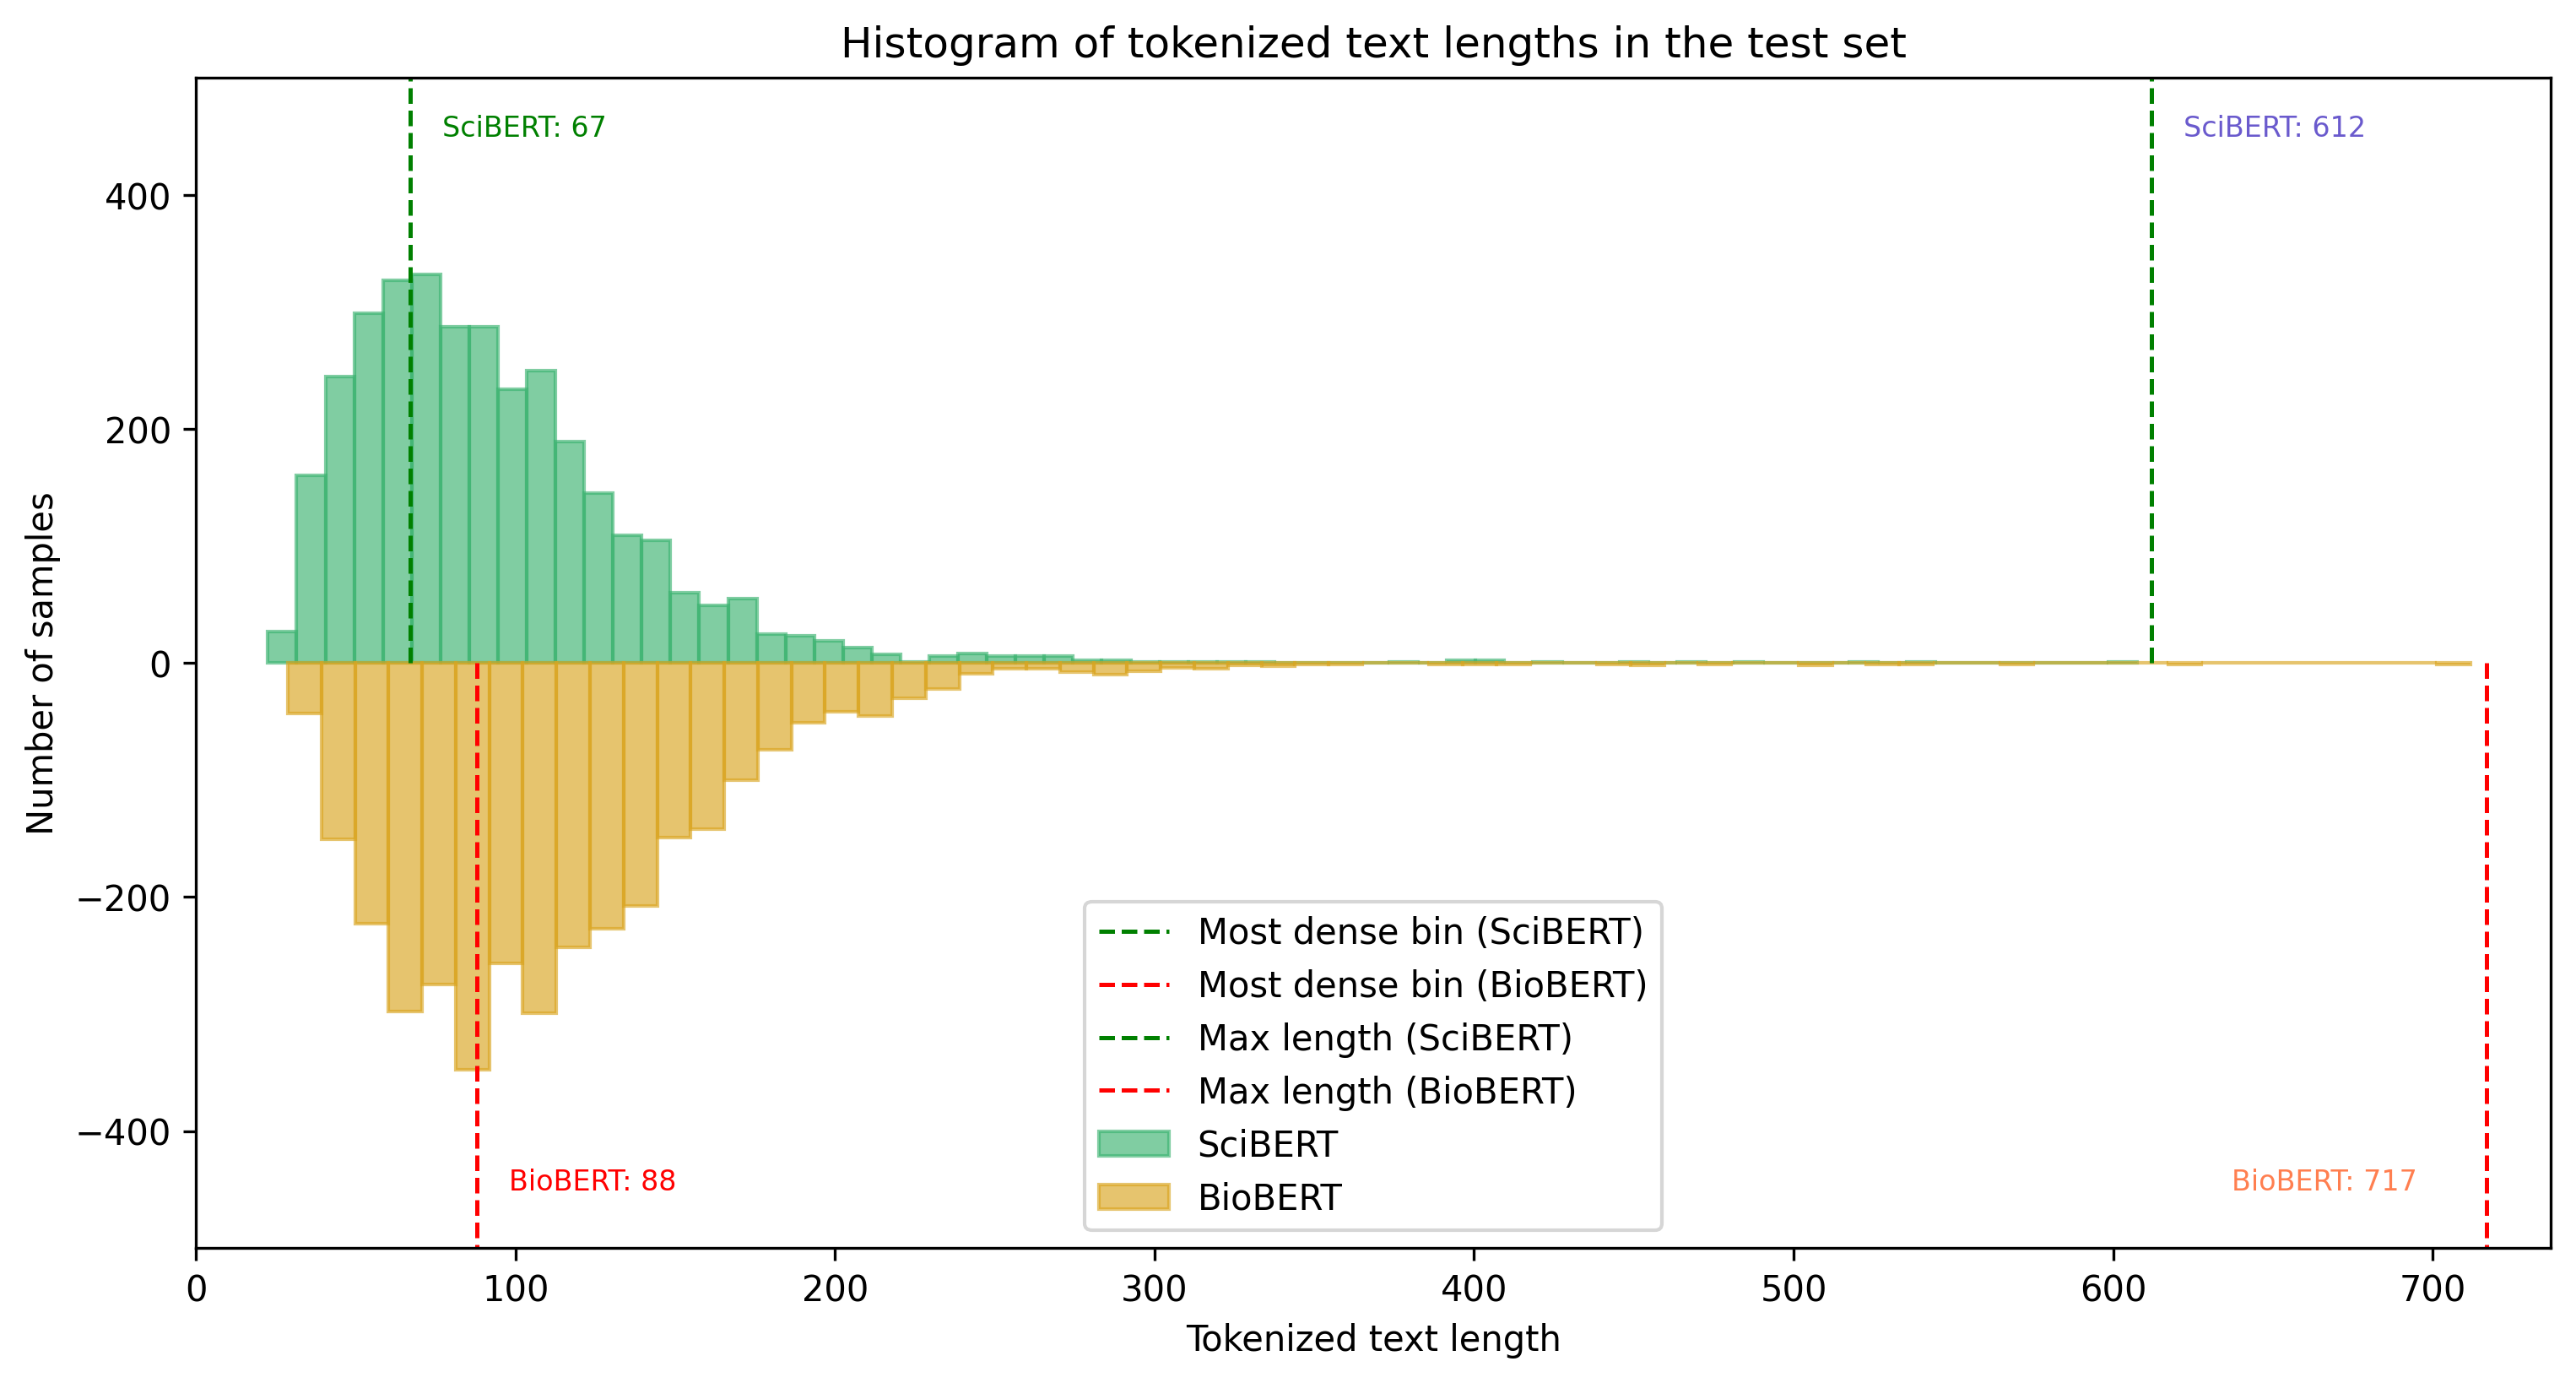

In [95]:
plt.figure(figsize=(12, 6), dpi=300)

heights, bins = np.histogram(test_descriptions["tokenized_length_scibert"], bins=65, density=False)
bin_width = np.diff(bins)[0]
plt.bar(bins[:-1], heights, width=bin_width, edgecolor='mediumseagreen', color='mediumseagreen', label="SciBERT", alpha=0.65)

heights, bins = np.histogram(test_descriptions["tokenized_length_biobert"], bins=65, density=False)
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos = bins[:-1]
plt.bar(bin_pos, heights, width=bin_width, edgecolor='goldenrod', color='goldenrod', label="BioBERT", alpha=0.65)
print(max(test_descriptions["tokenized_length_scibert"]))
print(max(test_descriptions["tokenized_length_biobert"]))

# Add vertical line for bin with most density
max_density_scibert = test_descriptions["tokenized_length_scibert"].value_counts().idxmax()
max_density_biobert = test_descriptions["tokenized_length_biobert"].value_counts().idxmax()

# Plot the line from 0 to 4000
plt.plot([max_density_scibert, max_density_scibert], [0, 6000], color='green', linestyle='--', linewidth=1.2, label="Most dense bin (SciBERT)")
plt.plot([max_density_biobert, max_density_biobert], [0, -6000], color='red', linestyle='--', linewidth=1.2, label="Most dense bin (BioBERT)")

plt.text(max_density_scibert + 10, 450, f"SciBERT: {max_density_scibert}", color='green', fontsize=8)
plt.text(max_density_biobert + 10, -450, f"BioBERT: {max_density_biobert}", color='red', fontsize=8)

max_length_scibert = max(test_descriptions["tokenized_length_scibert"])
max_length_biobert = max(test_descriptions["tokenized_length_biobert"])

plt.plot([max_length_scibert, max_length_scibert], [0, 500], color='green', linestyle='--', linewidth=1.2, label="Max length (SciBERT)")
plt.plot([max_length_biobert, max_length_biobert], [0, -500], color='red', linestyle='--', linewidth=1.2, label="Max length (BioBERT)")

plt.text(max_length_scibert + 10, 450, f"SciBERT: {max_length_scibert}", color='slateblue', fontsize=8)
plt.text(max_length_biobert - 80, -450, f"BioBERT: {max_length_biobert}", color='coral', fontsize=8)

plt.xlabel("Tokenized text length")
plt.ylabel("Number of samples")
plt.title("Histogram of tokenized text lengths in the test set")


plt.xlim(0, max(max_length_scibert, max_length_biobert)+20)
plt.ylim(-500, 500)
plt.legend()
plt.savefig("tokenized_text_length_test_set.png", dpi=300, transparent=True)